# Decision Tree and Ensemble Methods for Small Dataset

I decided to start trying to predict the ice/no ice condition in a single location, then we can extend it somehow to the full airfoil

First we check the properties of the dataset at hand:

In [98]:
# Import required packages
from __future__ import print_function
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.tree import DecisionTreeRegressor, export_graphviz, DecisionTreeClassifier
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, ExtraTreesClassifier, AdaBoostClassifier

import graphviz

    Temperture[K]  AoA[o]    Mach  MVD[mum]  rho[kg/m3]  0.617035028915481
0       249.83088 7.20324 0.30006   0.00002     0.52107                  1
1       236.84354 1.86260 0.47278   0.00003     0.84452                  0
2       249.91778 6.85220 0.40223   0.00005     0.42259                  1
3       259.96870 4.17305 0.57934   0.00002     0.56343                  0
4       265.17978 9.68262 0.45671   0.00004     1.12302                  1
5       268.93427 0.85044 0.31953   0.00002     1.12447                  0
6       237.08387 4.21108 0.77894   0.00003     0.97080                  0
7       245.77063 6.86501 0.71731   0.00001     1.01887                  0
8       272.70444 7.48166 0.44022   0.00004     0.48516                  1
9       251.06574 9.08596 0.44681   0.00002     0.50727                  1
10      233.92468 6.78836 0.40581   0.00002     0.80555                  1
11      235.28450 5.74118 0.37336   0.00003     0.97730                  1
12      237.24338 4.14056

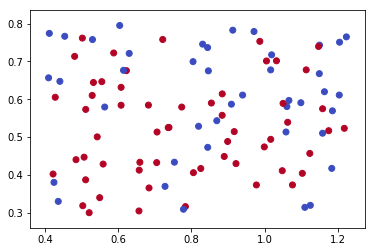

In [99]:
## UNDERSTANDING THE DATASET ##

# Setup pandas options
pd.options.display.max_rows = 30
pd.options.display.float_format = '{:.5f}'.format

# Get the data
PT_data = pd.read_excel("./PTResults_trimmed.xlsx")

print(PT_data)

plt.scatter(
    PT_data['rho[kg/m3]'], PT_data['Mach'],
    cmap="coolwarm",
    c=PT_data[0.617035028915481]
)

plt.show()

The "0.617035028915481" is just the value of the abscissa for which I'm doing the ice formation prediction. It goes from 0 to 1. We can see from the scatter plot that the data doesn't seem to follow any pattern...you can try with any 2 features and you'll see the same.

We check now for correlations in the data.

In [101]:
# Correlation in the data
print(PT_data.corr()) # In this abscissa there is correlation with the AoA

                   Temperture[K]   AoA[o]     Mach  MVD[mum]  rho[kg/m3]  \
Temperture[K]            1.00000  0.01392  0.08578  -0.00323    -0.04582   
AoA[o]                   0.01392  1.00000 -0.03209  -0.04491    -0.23167   
Mach                     0.08578 -0.03209  1.00000   0.11292     0.06428   
MVD[mum]                -0.00323 -0.04491  0.11292   1.00000     0.00756   
rho[kg/m3]              -0.04582 -0.23167  0.06428   0.00756     1.00000   
0.617035028915481        0.06188  0.70264 -0.28541   0.27280    -0.17986   

                   0.617035028915481  
Temperture[K]                0.06188  
AoA[o]                       0.70264  
Mach                        -0.28541  
MVD[mum]                     0.27280  
rho[kg/m3]                  -0.17986  
0.617035028915481            1.00000  


Ice formation in this location is dominated by the angle of attack with a 0.7 correlation level.

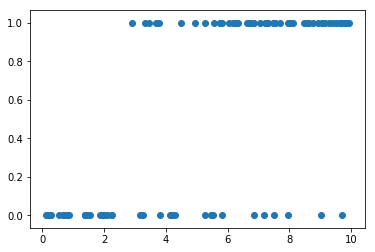

In [102]:
# Plotting the correlated features
plt.scatter(PT_data['AoA[o]'], PT_data[0.617035028915481])
plt.show()

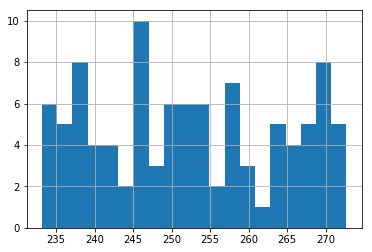

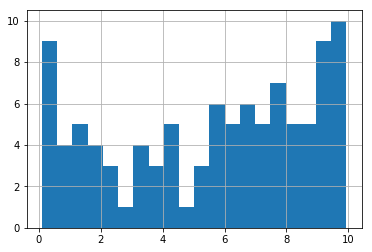

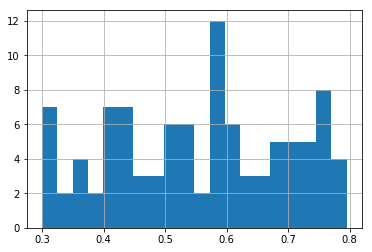

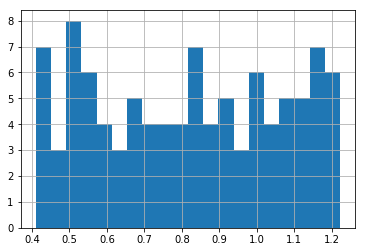

In [103]:
# Check that the data is evenly distributed so that MC was performed well
PT_data['Temperture[K]'].hist(bins=20)
plt.show()
PT_data['AoA[o]'].hist(bins=20)
plt.show()
PT_data['Mach'].hist(bins=20)
plt.show()
PT_data['rho[kg/m3]'].hist(bins=20)
plt.show()

Now we will train a Decision Tree Classifier to give us the ice/no ice condition on this portion of the airfoil under different conditions

In [104]:
## TRAINING THE DECISION TREE ##

target = 0.617035028915481
X = PT_data.drop(target, axis=1) # Just preparing the data
y = PT_data[target]

#Splitting the data into training and testing
training_features, testing_features, training_target, testing_target = train_test_split(
    X, y, test_size=0.3, shuffle=True)
print(training_features.describe())

       Temperture[K]   AoA[o]     Mach  MVD[mum]  rho[kg/m3]
count       70.00000 70.00000 70.00000  70.00000    70.00000
mean       252.43934  5.32131  0.56052   0.00003     0.81773
std         12.03018  3.13953  0.13775   0.00001     0.25573
min        233.16608  0.13952  0.30006   0.00001     0.41036
25%        242.50950  2.14058  0.43440   0.00002     0.57462
50%        252.41263  5.74415  0.58424   0.00003     0.84437
75%        263.10400  7.66632  0.67349   0.00004     1.05605
max        272.70444  9.88616  0.78242   0.00005     1.22279


This is just the training set features. The shuffle=True is important in case that the data is ordered in some specific way. Shuffling makes the testing and training datasets be distributed in the same way so that it makes sense to train with that portion of the data.

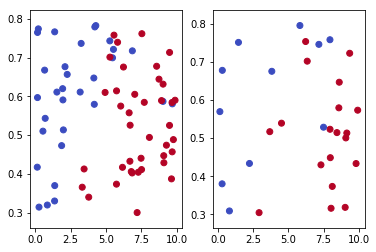

In [105]:
# Comparing distributions of training and testing datasets
fig, axes = plt.subplots(1,2)
axes[0].scatter(
    training_features['AoA[o]'], training_features['Mach'],
    cmap="coolwarm",
    c=training_target
)
axes[1].scatter(
    testing_features['AoA[o]'], testing_features['Mach'],
    cmap="coolwarm",
    c=testing_target
)
plt.show()

One could say that they both follow the same pattern...

In [106]:
#Training the DT
model = DecisionTreeClassifier(max_depth=1)
model.fit(training_features, training_target)

#Comparing prediction with testing values
prediction = model.predict(testing_features)
print('Prediction:', prediction)
print('Testing   :', np.array(testing_target))
print(mean_squared_error(prediction, testing_target))
print(int(30*mean_squared_error(prediction, testing_target)))

Prediction: [1 1 0 1 0 1 1 1 1 0 1 0 1 1 0 0 0 1 0 1 1 1 1 1 0 1 1 0 1 1]
Testing   : [1 1 0 1 0 1 0 0 1 0 1 0 1 1 0 0 1 1 0 0 1 1 1 1 1 0 1 1 1 1]
0.23333333333333334
7


Comparing the testing solutions to the predicted ones in a scatter colour plot.

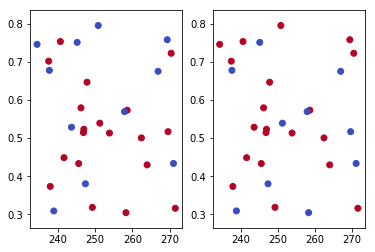

In [107]:
# Comparing distributions of training and testing datasets
fig, axes = plt.subplots(1,2)
axes[0].scatter(
    testing_features['Temperture[K]'], testing_features['Mach'],
    cmap="coolwarm",
    c=testing_target
)
axes[1].scatter(
    testing_features['Temperture[K]'], testing_features['Mach'],
    cmap="coolwarm",
    c=prediction
)
plt.show()

The mean squared error tells us how many times the Decision Tree got it wrong (check the last number). The following snippet is to be able to visualize the random tree created but I just get errors. You can try.

In [108]:
#dot_data = export_graphviz(
#    model, out_file=None, feature_names=list(training_features), filled=True, 
#    rounded=True, special_characters=True)
#graph = graphviz.Source(dot_data)
#graph.render("Ice formation") 
#graph 

Next, I tried different ensemble methods that suposedly improved the prediction of a single tree. Here you have Bagging, Random Forest, Extemely Randomized Tree (WTF) and Boosting. But first, I did 1000 times the procedure before to have a distribution on the error gotten with the decision tree when using different groups of the data for testing and training.

In [109]:
training_features_vector = []
testing_features_vector = []
training_target_vector = []
testing_target_vector = []

for i in range(1000):
    
    training_features, testing_features, training_target, testing_target = train_test_split(
        X, y, test_size=30, shuffle=True)
    #store
    training_features_vector.append(training_features)
    testing_features_vector.append(testing_features)
    training_target_vector.append(training_target)
    testing_target_vector.append(testing_target)

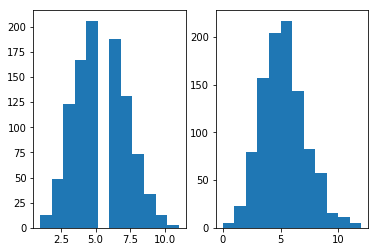

In [110]:
MSE_vector_3=[]
MSE_vector_10=[]
ncells_missclass_3=[]
ncells_missclass_10=[]

for i in range(1000):
    training_features = training_features_vector[i]
    testing_features = testing_features_vector[i]
    training_target = training_target_vector[i]
    testing_target = testing_target_vector[i]

    #Training with Decision Tree
    model_3 = DecisionTreeClassifier(max_depth=3)
    model_3.fit(training_features, training_target)
    model_10 = DecisionTreeClassifier(max_depth=10)
    model_10.fit(training_features, training_target)

    #Comparing prediction with testing values
    prediction_3 = model_3.predict(testing_features)
    prediction_10 = model_10.predict(testing_features)
    
    #MSE and number of missclassified cells distributions
    MSE_3 = mean_squared_error(prediction_3, testing_target)
    MSE_10 = mean_squared_error(prediction_10, testing_target)
    MSE_vector_3.append(MSE_3)
    MSE_vector_10.append(MSE_10)
    ncells_missclass_3.append(30*mean_squared_error(prediction_3, testing_target))
    ncells_missclass_10.append(30*mean_squared_error(prediction_10, testing_target)) 
    
#plt.hist(MSE_vector, bins=10)
#plt.hist(ncells_missclass_3, bins=12)
#plt.show()

# Comparing distributions for depth 3 and 10
fig, axes = plt.subplots(1,2)
axes[0].hist(ncells_missclass_3, bins=12)
axes[1].hist(ncells_missclass_10, bins=12)
plt.show()

Next, I did the same for Extra Trees and the other ensemble methods.

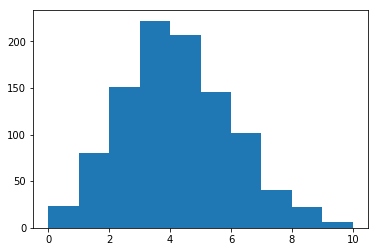

In [14]:
#Extra Tree

MSE_vector=[]
ncells_missclass=[]
for i in range(1000):
    training_features = training_features_vector[i]
    testing_features = testing_features_vector[i]
    training_target = training_target_vector[i]
    testing_target = testing_target_vector[i]

    #Training with Extra Trees
    randomized_trees = ExtraTreesClassifier(max_depth=10)
    randomized_trees.fit(training_features, training_target)

    #Comparing prediction with testing values
    prediction = randomized_trees.predict(testing_features)
    
    #MSE and number of missclassified cells distributions
    MSE = mean_squared_error(prediction, testing_target)
    MSE_vector.append(MSE)
    ncells_missclass.append(30*mean_squared_error(prediction, testing_target))
    
#plt.hist(MSE_vector, bins=10)
plt.hist(ncells_missclass, bins=10)
plt.show()

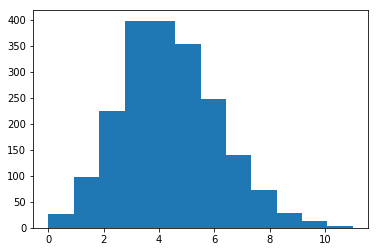

In [15]:
#Bagging
for i in range(1000):
    training_features = training_features_vector[i]
    testing_features = testing_features_vector[i]
    training_target = training_target_vector[i]
    testing_target = testing_target_vector[i]

    #Training with Extra Trees
    bagging=BaggingClassifier(
    DecisionTreeClassifier(max_depth=10),
    n_estimators=100, max_samples=0.5, max_features=0.5
    )
    bagging.fit(training_features, training_target)

    #Comparing prediction with testing values
    prediction = bagging.predict(testing_features)
    
    #MSE and number of missclassified cells distributions
    MSE = mean_squared_error(prediction, testing_target)
    MSE_vector.append(MSE)
    ncells_missclass.append(30*mean_squared_error(prediction, testing_target))
    
#plt.hist(MSE_vector, bins=10)
plt.hist(ncells_missclass, bins=12)
plt.show()

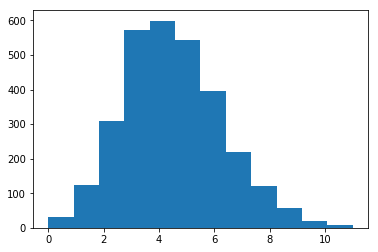

In [16]:
#Boosting
for i in range(1000):
    training_features = training_features_vector[i]
    testing_features = testing_features_vector[i]
    training_target = training_target_vector[i]
    testing_target = testing_target_vector[i]

    #Training with Extra Trees
    boosted = AdaBoostClassifier(
    DecisionTreeClassifier(max_depth=10), n_estimators=10)
    boosted.fit(training_features, training_target)

    #Comparing prediction with testing values
    prediction = boosted.predict(testing_features)
    
    #MSE and number of missclassified cells distributions
    MSE = mean_squared_error(prediction, testing_target)
    MSE_vector.append(MSE)
    ncells_missclass.append(30*mean_squared_error(prediction, testing_target))
    
#plt.hist(MSE_vector, bins=10)
plt.hist(ncells_missclass, bins=12)
plt.show()

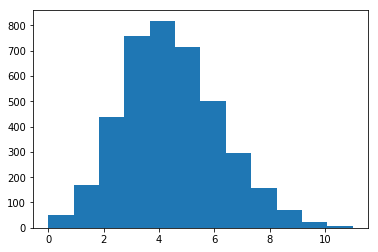

In [17]:
#Random Forest
for i in range(1000):
    training_features = training_features_vector[i]
    testing_features = testing_features_vector[i]
    training_target = training_target_vector[i]
    testing_target = testing_target_vector[i]

    #Training with Extra Trees
    random_forest = RandomForestClassifier(max_depth=10)
    random_forest.fit(training_features, training_target)

    #Comparing prediction with testing values
    prediction = random_forest.predict(testing_features)
    
    #MSE and number of missclassified cells distributions
    MSE = mean_squared_error(prediction, testing_target)
    MSE_vector.append(MSE)
    ncells_missclass.append(30*mean_squared_error(prediction, testing_target))
    
#plt.hist(MSE_vector, bins=10)
plt.hist(ncells_missclass, bins=12)
plt.show()

In [14]:
## ENSEMBLE METHODS ##

#Bagging
bagging = BaggingClassifier(
    DecisionTreeClassifier(max_depth=10),
    n_estimators=100, max_samples=0.5, max_features=0.5
)
bagging.fit(training_features, training_target)
bagging_prediction = bagging.predict(testing_features)
print('Bagging MSE:', mean_squared_error(bagging_prediction, testing_target))

#Random Forest
random_forest = RandomForestClassifier(max_depth=10)
random_forest.fit(training_features, training_target)
rf_prediction = random_forest.predict(testing_features)
print('RF MSE:', mean_squared_error(rf_prediction, testing_target))

#Extremely Randomized Tree
randomized_trees = ExtraTreesClassifier(max_depth=10)
randomized_trees.fit(training_features, training_target)
rt_prediction = randomized_trees.predict(testing_features)
print('ERT MSE:', mean_squared_error(rt_prediction, testing_target))

#Boosting
boosted = AdaBoostClassifier(
    DecisionTreeClassifier(max_depth=10), n_estimators=10)
boosted.fit(training_features, training_target)
boosted_prediction = boosted.predict(testing_features)
print('Boosting:', mean_squared_error(boosted_prediction, testing_target))

Bagging MSE: 0.16666666666666666
RF MSE: 0.1
ERT MSE: 0.03333333333333333
Boosting: 0.2


Plotting the MSE for each of the four ensemble methods above versus the maximum depth used (from 2 to 20).

2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20


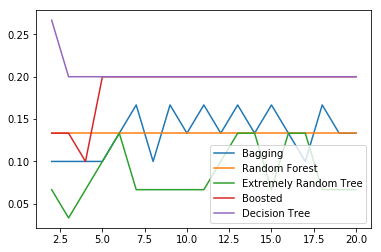

In [15]:
def test_error(model):
    model.fit(training_features, training_target)
    prediction = model.predict(testing_features)
    return mean_squared_error(prediction, testing_target)


min_depth = 2
max_depth = 20

estimators = 100

mse = np.zeros((max_depth - min_depth + 1, 5))
for i, D in enumerate(range(2, max_depth + 1)):
    print(D)
    model = BaggingClassifier(
        DecisionTreeClassifier(max_depth=D),
        n_estimators=estimators, max_samples=0.5, max_features=0.5
    )
    mse[i, 0] = test_error(model)

    model = RandomForestClassifier(max_depth=D, n_estimators=estimators)
    mse[i, 1] = test_error(model)

    model = ExtraTreesClassifier(max_depth=D, n_estimators=estimators)
    mse[i, 2] = test_error(model)

    model = AdaBoostClassifier(
        DecisionTreeClassifier(max_depth=D), n_estimators=estimators)
    mse[i, 3] = test_error(model)
    
    model = DecisionTreeClassifier(max_depth=D)
    mse[i, 4] = test_error(model)


plt.plot(range(min_depth, max_depth+1), mse[:,0])
plt.plot(range(min_depth, max_depth+1), mse[:,1])
plt.plot(range(min_depth, max_depth+1), mse[:,2])
plt.plot(range(min_depth, max_depth+1), mse[:,3])
plt.plot(range(min_depth, max_depth+1), mse[:,4])
plt.legend(['Bagging', 'Random Forest', 'Extremely Random Tree', 'Boosted', 'Decision Tree'])
plt.show()

It seems that the Extremely Randomized Tree performs better overall. It looks quite discreet because everytime there is an error is a jump of value one...

The previous chunk of notebook was devoted to the classification for ice/no ice condition on a single location on an airfoil. Now, we are going to attempt the prediction of ice formation for different conditions on all parts of the airfoil.

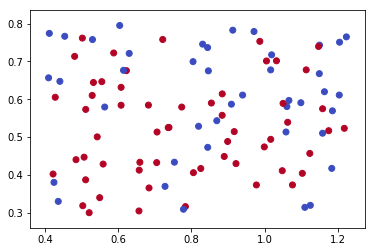

In [130]:
## UNDERSTANDING THE DATASET ##

# Setup pandas options
pd.options.display.max_rows = 10
pd.options.display.float_format = '{:.5f}'.format

# Get the data
PT_data = pd.read_excel("../../Data/PTResults_ice.xlsx")

plt.scatter(
    PT_data['rho[kg/m3]'], PT_data['Mach'],
    cmap="coolwarm",
    c=PT_data[0.617035028915481]
)

plt.show()

In [131]:
# Correlation in the data
print(PT_data.corr())

                   Temperture[K]   AoA[o]     Mach  MVD[mum]  rho[kg/m3]  \
Temperture[K]            1.00000  0.01392  0.08578  -0.00323    -0.04582   
AoA[o]                   0.01392  1.00000 -0.03209  -0.04491    -0.23167   
Mach                     0.08578 -0.03209  1.00000   0.11292     0.06428   
MVD[mum]                -0.00323 -0.04491  0.11292   1.00000     0.00756   
rho[kg/m3]              -0.04582 -0.23167  0.06428   0.00756     1.00000   
...                          ...      ...      ...       ...         ...   
0.911720998889302        0.04221  0.23218 -0.23328   0.21361     0.00775   
0.920169346538318        0.04221  0.23218 -0.23328   0.21361     0.00775   
0.928429952225461       -0.01534  0.18983 -0.22674   0.20355    -0.06355   
0.936541946531039       -0.01534  0.18983 -0.22674   0.20355    -0.06355   
0.944463340691671       -0.13493  0.17487 -0.15464   0.19279    -0.06751   

                   0.428520273131699  0.434472523762012  0.439817063795185  \
Tempertur

In [132]:
## TRAINING THE DECISION TREE ##

#target = [0,0.00847867126218693,0.609477617930035,0.617035028915481,0.636371419678129,0.936541946531039]
target=PT_data.iloc[:,6:128]
X = PT_data.drop(target, axis=1) # Just preparing the data
y = target

#Splitting the data into training and testing
training_features, testing_features, training_target, testing_target = train_test_split(
    X, y, test_size=0.3, shuffle=True)

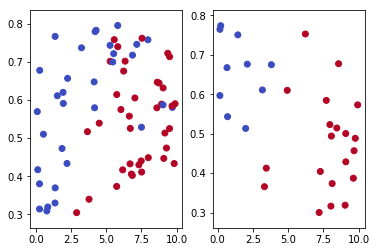

In [133]:
# Comparing distributions of training and testing datasets on a given location
fig, axes = plt.subplots(1,2)
axes[0].scatter(
    training_features['AoA[o]'], training_features['Mach'],
    cmap="coolwarm",
    c=training_target[0.617035028915481]
)
axes[1].scatter(
    testing_features['AoA[o]'], testing_features['Mach'],
    cmap="coolwarm",
    c=testing_target[0.617035028915481]
)
plt.show()

In [134]:
#Training the DT
model = DecisionTreeClassifier(max_depth=1)
model.fit(training_features, training_target)

#Comparing prediction with testing values
prediction = model.predict(testing_features)
print('Prediction:', prediction)
print('Testing   :', np.array(testing_target))

lst_pred = [item[92] for item in prediction]
lst_test = [item[92] for item in np.array(testing_target)]
    
print(mean_squared_error(lst_pred, lst_test))
print(int(30*mean_squared_error(lst_pred, lst_test)))

Prediction: [[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
Testing   : [[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
0.06666666666666667
2


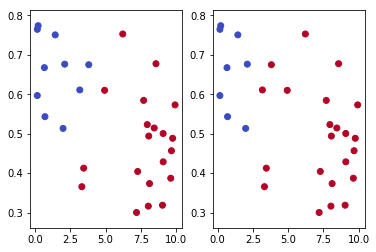

In [135]:
# Comparing distributions of training and testing datasets

#Getting first/second/third... whatever component of the vectors
#making up a list of vectors such as in the prediction list
lst2 = [item[92] for item in prediction]

fig, axes = plt.subplots(1,2)
axes[0].scatter(
    testing_features['AoA[o]'], testing_features['Mach'],
    cmap="coolwarm",
    c=testing_target[0.617035028915481]
)
axes[1].scatter(
    testing_features['AoA[o]'], testing_features['Mach'],
    cmap="coolwarm",
    c=lst2
)
plt.show()

We repeat the process 1000 times and compute the distributions per location.

In [136]:
training_features_vector = []
testing_features_vector = []
training_target_vector = []
testing_target_vector = []

for i in range(1000):
    
    training_features, testing_features, training_target, testing_target = train_test_split(
        X, y, test_size=30, shuffle=True)
    #store
    training_features_vector.append(training_features)
    testing_features_vector.append(testing_features)
    training_target_vector.append(training_target)
    testing_target_vector.append(testing_target)

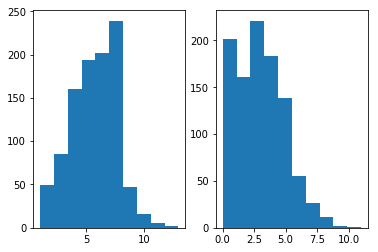

In [137]:
MSE_vector_3=[]
MSE_vector_10=[]
ncells_missclass_3=[]
ncells_missclass_10=[]

for i in range(1000):
    training_features = training_features_vector[i]
    testing_features = testing_features_vector[i]
    training_target = training_target_vector[i]
    testing_target = testing_target_vector[i]

    #Training with Decision Tree
    model_3 = DecisionTreeClassifier(max_depth=3)
    model_3.fit(training_features, training_target)
    model_10 = DecisionTreeClassifier(max_depth=10)
    model_10.fit(training_features, training_target)

    #Comparing prediction with testing values
    prediction_3 = model_3.predict(testing_features)
    prediction_10 = model_10.predict(testing_features)
    lst3 = [item[92] for item in prediction_3]
    lst10 = [item[92] for item in prediction_10]
    
    testing_target=np.array(testing_target)
    lst3t = [item[92] for item in testing_target]
    
    #MSE and number of missclassified cells distributions
    MSE_3 = mean_squared_error(lst3, lst3t)
    MSE_10 = mean_squared_error(lst10, lst3t)
    MSE_vector_3.append(MSE_3)
    MSE_vector_10.append(MSE_10)
    ncells_missclass_3.append(30*mean_squared_error(lst3, lst3t))
    ncells_missclass_10.append(30*mean_squared_error(lst10, lst3t)) 
    
#plt.hist(MSE_vector, bins=10)
#plt.hist(ncells_missclass_3, bins=12)
#plt.show()

# Comparing distributions for depth 3 and 10
fig, axes = plt.subplots(1,2)
axes[0].hist(ncells_missclass_3, bins=10)
axes[1].hist(ncells_missclass_10, bins=10)
plt.show()